<H1><CENTER> Machine Learning Lab - Exercise Sheet 7 <br /></CENTER></H1>
<H2><CENTER> Author: Sebastian Pineda Arango  <br />
ID: 246098<br />
Universität Hildesheim - Data Analytics Master </CENTER></H2>

<img src="https://www.uni-hildesheim.de/typo3conf/ext/unihildesheim/Resources/Public/Images/logo-uni.svgz" width="100">


## Exercise sheet 7

In this exercise sheet, two methods are examinated: K-Nearest neighbours and decision trees. The data set used to train the models is the classical iris data set [1].

The data set is imported from the moule _datasets_ include in scikit-learn. We also explore the shape, some descriptive statistics and the distributions of the labels of the dataset. Afterwards, some insights are extracted from the dataset:

* There are 150 samples
* 4 features (corresponding to width and length of petals and sepals.
* The classes are balanced: the number of samples for each class is roughly the same
* The descriptors change the scale, therefore it is neccesary to rescale so tht distance based methods perform better.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import statistics as st
from sklearn.base import BaseEstimator


%matplotlib inline

In [20]:
data = datasets.load_iris()
X = data.data
X.shape

(150, 4)

In [21]:
Y = data.target
Y.shape

(150,)

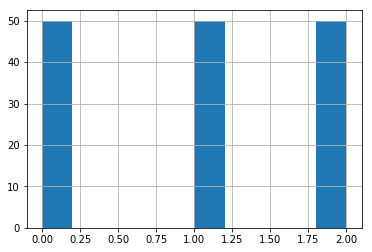

In [22]:
plt.hist(Y)
plt.grid()

In [23]:
pd.DataFrame(X).describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Exercise 1: Implement K-Nearest Neighbor (KNN)

Before proceeding, two operations are applied over the dataset:

* We divide data set in training and test set (70/30).
* We fit a standard scaler over the training set and we transform it on test set. To chech that it was rescaled, we get the basic statisctis again. Afterwards, the mean is effectively zero and the standard deviation is one.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Splitting train-test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
scaler = StandardScaler()

#Standarizing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Finding main descriptors of the data
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3
count,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02
mean,-5.202188e-16,6.952111e-16,2.008975e-16,-5.075305e-16
std,1.004796e+00,1.004796e+00,1.004796e+00,1.004796e+00
min,-1.796993e+00,-2.409310e+00,-1.454129e+00,-1.382159e+00
25%,-8.553371e-01,-5.844044e-01,-1.231070e+00,-1.254406e+00
50%,-3.138852e-02,-1.281779e-01,3.303390e-01,1.508694e-01
75%,6.748531e-01,5.561618e-01,7.764560e-01,7.896312e-01
max,2.440457e+00,3.065407e+00,1.780219e+00,1.683898e+00


A class is implemented that wraps many functionalities of the KNN classifier. This class heritates from Scikit-learn BaseEstimator (so that it can be used along with other scikit-learn funcionalities). The class defines also several methods:

- Constructor (__init__ method): used to initialize k when the object is created.
- fit: to train the model. Since KNN has no model, we storage the training and test set.
- predict: to make predictions over a given test set.
- score: to find the accuracy over a test set.
- find knn: return a list of nearst neighbours
- eucliden distance: find the euclidean distance between different rows of a matrix and a query vector.

Accuracy is chosen as performance measure, since the label distribution is balanced. Otherwhise, we should use another measure, less sensible to label distribution (lik F1-Score). We can define accuracy as:

$Accuracy = \frac{TP+TN}{S}$

Where TP are True Positives, TN are True Negatives and S is the size of the whole set. We could also define accuracy as:

$Accuracy = \sum{I(y=\hat{y})}$

Where $I=1$ if $y=\hat{y}$, and $I=0$ otherwise.

Finally, an object is created to make predictions over a test set using KNN (k=3) and then, we find, the accuracy over a test set.


In [25]:
#class knn estimator

class knn_estimator (BaseEstimator):
    
    def __init__(self,k):
        
        '''Intialize the hyperparameter k (number of nearest neighbors to look for)'''
        
        self.k=k
        
    def fit(self, X_train, y_train):
        
        '''Save the train set (features and labels) to be able to make predictions in the future'''
        
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):

        '''Make predictions over the X_test using KNN'''
        
        n_test_samples = X_test.shape[0]
        predictions = []

        for i in range(n_test_samples):
            X_query = X_test[i,:]
            (top_k, idx) = self.find_knn(self.X_train, X_query, self.k)
            #pred_class = st.mode(self.y_train[idx,])
            pred_class= max(set(list(self.y_train[idx,].tolist())), key=self.y_train.tolist().count)
            predictions.append(pred_class)
            
        return np.array(predictions)

    def score(self, X, y):
        
        '''Find the accuracy oF the predictions over X given the y labels'''
        
        y_pred = self.predict(X)
        acc=np.mean(y==y_pred)
        
        return acc
    
    def find_knn(self, X, X_query, k):
        
        '''Find the k-nearest neighbors of X_query among the samples in X '''
        
        dist = self.euclidean_distance(X, X_query)
        idx = np.argsort(dist.T[0], axis=0)[:k]
        top_k = X[idx,:]
        return top_k, idx      
    
    def euclidean_distance(self, X, X_query):

        '''Find the euclidean distance between X_query (single sample) and X
           (matrix where each row is a sample)'''
        
        if X.shape[1] != X_query.shape[0]:
            print("Dimensions doesn't match.")

        dist = np.zeros((X.shape[0], 1))

        for i in range(X.shape[0]):
                dist[i] = np.sqrt(np.sum((X[i,:]-X_query)**2))

        return dist


k=5
knn_clf = knn_estimator(k)
knn_clf.fit(X_train, y_train)
acc = knn_clf.score(X_test, y_test)
acc

0.93333333333333335

### Exercise 2 - Part A: Optimize and compare KNN algorithm 



To determine the optimal value of K in KNN, we will use grid search with cross validation. For that we apply k-fold cross validation [2] and tried a different set of hyperparameters. At the end, we choose the hyperparameter with the highest mean accuracy for the k-fold.

Note that the hyperparameter that we aim to fin is the number of neighbors (K).

Text(0,0.5,'Accuracy')

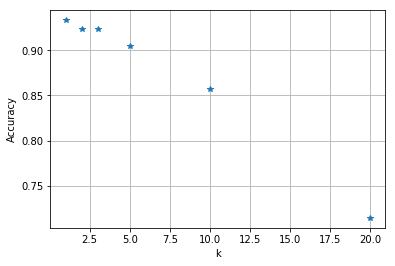

In [26]:
#number of samples of training set
n_train = X_train.shape[0]

#number of folds
n_folds = 5

#initializing folds
folds = []
samples_fold = int(n_train/n_folds)

#creating the k-fold subsets
for i in range(n_folds):
    
    folds.append((X_train[(i*samples_fold):((i+1)*samples_fold),:],
                   y_train[(i*samples_fold):((i+1)*samples_fold)]))

folds_list = list(range(n_folds+1))

#initialize list to store the man of each hyperparameter setting
mean_test_folds = []

#list of hyperparameters
k_list = [1,2,3,5,10,20]

for k in k_list:

    test_acc_folds = []
    
    for f in range(n_folds):

            #list of folds
            folds_list = list(range(n_folds))
            folds_list.pop(f)

            #selecting test dataset
            X_test_fold = folds[f][0]
            y_test_fold = folds[f][1]

            #merging the folds to create the training dataset
            X_train_fold = folds[folds_list[1]][0]   
            y_train_fold = folds[folds_list[1]][1]
            
            for j in folds_list[1:]:
                X_train_fold = np.vstack((X_train_fold, folds[j][0]))
                y_train_fold = np.hstack((y_train_fold, folds[j][1]))

            #creating base estimator
            knn_clf = knn_estimator(k)
            
            #saving the X_train and y_train
            knn_clf.fit(X_train_fold, y_train_fold)
            
            #finding accuracy over the fold
            acc_test = knn_clf.score(X_test_fold, y_test_fold)
            test_acc_folds.append(acc_test)
            
    #findning the mean across all the folds
    mean_test_folds.append(np.mean(test_acc_folds))

plt.plot(k_list, mean_test_folds, '*') 
plt.grid()
plt.xlabel("k")
plt.ylabel("Accuracy")

After running cross validation, we can see that the best value for the hyperparameters is K=1. We also validate this result using _GridSearch_ function of Scikit learn. We can do this since we have created the knn_stimator class with the same interface as an estimator class of Scikit-learn. This also returns that the best value for K is 1.

In [27]:
from sklearn.model_selection import GridSearchCV

knn_clf = knn_estimator(3)
parameters={'k':k_list}
knn_grid = GridSearchCV(knn_clf, parameters, cv=5)
knn_grid.fit(X_train, y_train)
best_knn= knn_grid.best_estimator_
best_knn

knn_estimator(k=2)

To give evidence that this value is the better, we try on test set different values for K. As we can see, the greater the value of K, the lower the accuracy. The graph show that the best and lowest value for K is K=1.

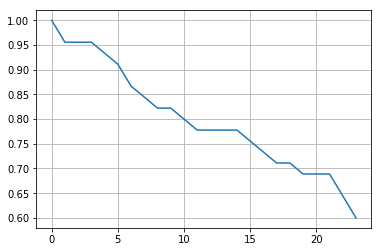

In [28]:
acc_list = []

for i in range(1,25):
    knn_clf = knn_estimator(i)
    knn_clf.fit(X_train, y_train)
    acc = knn_clf.score(X_test, y_test)
    acc_list.append(acc)
plt.plot(acc_list)
plt.grid()

### Exercise 2 - Part B: Comparison of KNN with Tree based methods

The perforamnce of decision tree and KNN is compared using the test set and analyzing the stability of the results using cross_val_score. The idea is that the results do not be very deviated from a mean value. 

Hyperparameter search is applied over the decision trees. In this case, we vary maximal depth of the tree as hyperparameter. We can see that the best tree is the one with max_depth = 3. 

Best tree: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Text(0,0.5,'Accuracy')

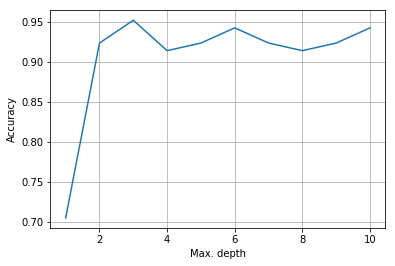

In [31]:
from sklearn import tree

parameters = {'max_depth':list(range(1,11))}

#creating the classifier
tree_clf = tree.DecisionTreeClassifier()
tree_grid = GridSearchCV(tree_clf, parameters, cv=5)

#performing hyperparameter search
tree_grid.fit(X_train, y_train)

#finding the best decision tree
best_tree = tree_grid.best_estimator_

print("Best tree:", best_tree)

#pltting differen results
x_axis = [i['max_depth'] for i in tree_grid.cv_results_['params']]
x_axis
y_axis = tree_grid.cv_results_['mean_test_score']

plt.plot(x_axis, y_axis)
plt.grid()
plt.xlabel("Max. depth")
plt.ylabel("Accuracy")

Results for the best tree:
Mean of results: 0.95
Standard deviation of results: 0.04472135955


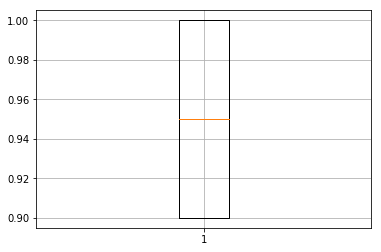

In [32]:
from sklearn.model_selection import cross_val_score

metrics_tree = cross_val_score(best_tree, X_train, y_train, cv=5)
plt.boxplot(metrics_tree)
plt.grid()

print("Results for the best tree:")
print("Mean of results:", np.mean(metrics_tree))
print("Standard deviation of results:", np.std(metrics_tree))

Results for the best KNN classifier:
Mean of results: 0.952380952381
Standard deviation of results: 0.042591771


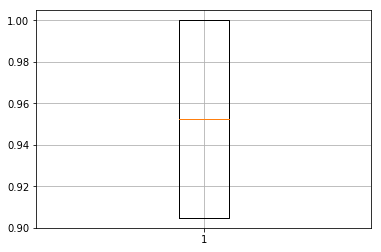

In [33]:
from sklearn.model_selection import cross_val_score

metrics_knn = cross_val_score(best_knn, X_train, y_train, cv=5)
plt.boxplot(metrics_knn)
plt.grid()

print("Results for the best KNN classifier:")
print("Mean of results:", np.mean(metrics_knn))
print("Standard deviation of results:", np.std(metrics_knn))

In [34]:
#Evaluation on test set
acc_knn_test = best_knn.score(X_test, y_test)
acc_tree_test = best_tree.score(X_test, y_test)

print("Accuracy of KNN:", acc_knn_test)
print("Accuracy of tree:", acc_tree_test)

Accuracy of KNN: 0.955555555556
Accuracy of tree: 0.933333333333


The KNN classifier performs _slightly_ better than decision tree. In fact, during the creation of this notebook, the reuslts have changed a little bit between different runs. In this case, we can see that the accuracy on test set is better for KNN, however, due to the small size of test set (45 samples), this difference only means one wrongly classified sample.

At the end of the day, although the KNN seems to perform _slightly_ better (at least for this run), the decision tree could be better in other aspects. For instance, decision tree stores few parameters to make predictions, while KNN has to store the whole training set. Moreover, in spite of a lacking  execution time comparisons, it is highly probable that the decision tree is faster than KNN, since the former has only to evaluate a few conditions, while the last one has to calculate the euclidean distance respect to every training sample.

## References

* Iris data set: https://en.wikipedia.org/wiki/Iris_flower_data_set
* K-Fold cross validation: https://machinelearningmastery.com/k-fold-cross-validation/
